In [1]:
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
import itertools
import numpy as np
from matplotlib import pyplot as plt
import requests
import json
from collections import OrderedDict

## This notebook allows the evolution the blockage features

(blockedPassengerRatio and conflictFreePassengerSeatingRatio)

In [2]:
#Setup of important variables
uri = "localhost:27017"
client = MongoClient(uri, server_api=ServerApi('1'))

client.admin.command('ping')

db = client.test
historical_evolution_data = db.historicalEvolutionData
problem_instances = db.probleminstances
db_prelim_information = db.prelimInformation
conflict_evolution_data = db.conflictEvolutionData

generator_colors = {
    "SimpleGenerator" : "orange",
    "RealisticGenerator" : "blue",
    "LocalSearchController" : "green"
}

plt_xlim = [-0.05,1.05]
plt_ylim = [-0.05,1.05]

experiment_id = "27-09-1000"

x_axis_feature = "blockedPassengerRatio"
y_axis_feature = "conflictFreePassengerSeatingRatio"


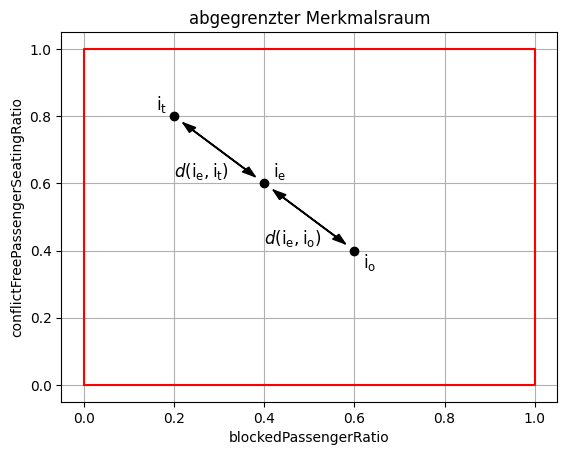

In [3]:
plt.title("abgegrenzter Merkmalsraum")
plt.xlabel(x_axis_feature)
plt.ylabel(y_axis_feature)

ax = plt.gca()
ax.set_axisbelow(True)

plt.arrow(0.38,0.62,-0.16,0.16, length_includes_head=True, head_width=0.02, head_length=0.03, fc='k', ec='k')
plt.arrow(0.22,0.78,0.16,-0.16, length_includes_head=True, head_width=0.02, head_length=0.03, fc='k', ec='k')

plt.arrow(0.58,0.42,-0.16,0.16, length_includes_head=True, head_width=0.02, head_length=0.03, fc='k', ec='k')
plt.arrow(0.42,0.58,0.16,-0.16, length_includes_head=True, head_width=0.02, head_length=0.03, fc='k', ec='k')

plt.scatter(0.6,0.4, color="black")
plt.text(0.62,0.35,  "$\mathregular{i_o}$", fontsize = 12) 

plt.scatter(0.4,0.6, color="black")
plt.text(0.42,0.62,  "$\mathregular{i_e}$", fontsize = 12) 

plt.scatter(0.2,0.8, color="black")
plt.text(0.16,0.82,  "$\mathregular{i_t}$", fontsize = 12) 

plt.text(0.2,0.62,  "$d(\mathregular{i_e},\mathregular{i_t})$", fontsize = 12) 
plt.text(0.4,0.42,  "$d(\mathregular{i_e},\mathregular{i_o})$", fontsize = 12) 


borders = [[0,0],[1,0],[1,1],[0,1],[0,0]]
xs, ys = zip(*borders)
plt.plot(xs, ys, color= "red")

plt.xlim(plt_xlim)
plt.ylim(plt_ylim)
    
plt.grid()
plt.show()

In [4]:
# call to backend for evolving conflicts
def post_conflict_evolution(experiment_id, instance, mutation_name, conflict_coords):
    url = 'http://localhost:8080/conflict/evolution'
    data = {
    "experimentId" : experiment_id,
    "instanceCount" : 50,
    "mutationName" : mutation_name,
    "instance" : instance,
    "conflictCoordinates" : conflict_coords
    }
    headers = {'Content-Type': 'application/json'}

    requests.post(url, json=data, headers=headers)


In [6]:
# Finding an instance to evolve with certain characteristics 
instances = problem_instances.find({"experimentId" : "27-09-1000", "featureDescription.totalCongestion" : {"$gte" : 0.78}, "featureDescription.totalPassengerCount" : {"$lte" : 200}})

for instance in instances:
    railcarriages = instance["problem"]["train"]["railCarriages"]
    railcarriages = list(map(lambda x: x["capacity"], railcarriages))
    if (0 in railcarriages and len(railcarriages) > 2):
        x = 1
        print(instance["instanceId"] + " " +  str(instance["featureDescription"]["totalPassengerCount"]))

mk_s_41 168


In [9]:
def plot_conflict_evolution(evolution_data):
    start_generation_x_coords = [data[x_axis_feature] for data in evolution_data["startGeneration"]]
    start_generation_y_coords = [data[y_axis_feature] for data in evolution_data["startGeneration"]]
    plt.scatter(start_generation_x_coords, start_generation_y_coords, color= "blue", label="Startpopulation")

    for history in evolution_data["coordinateHistories"]:
        history_x_coords = [data[x_axis_feature] for data in history]
        history_y_coords = [data[y_axis_feature] for data in history]
        plt.scatter(history_x_coords, history_y_coords, color= "green",label="$\mathregular{i_e}$")

    plt.scatter(evolution_data["startCoordinates"][x_axis_feature],evolution_data["startCoordinates"][y_axis_feature], color="red",label="$\mathregular{i_o}$")

    plt.title(evolution_data["instanceId"])
    plt.xlabel(x_axis_feature)
    plt.ylabel(y_axis_feature)

    plt.xlim(plt_xlim)
    plt.ylim(plt_ylim)
    
    plt.grid()
    return plt

## Importance of clean data! 

Unfortunately there are 2 known inconveniences if you take the instance data from mongodb.
(+ The backend does have some unclean code)

- Remove NaN solution values or else backend can't handle it
- Replace passenger property "_id" with "id" (caused by a design mistake of POJO classes that propagated through the whole development)

### Shown here is the result of using MoveInOrOutPosition:

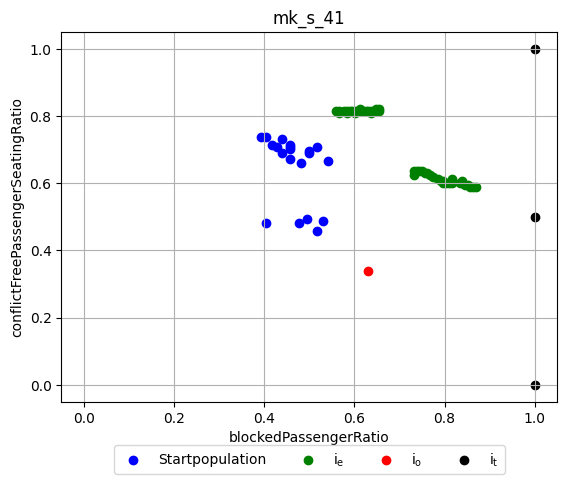

In [40]:
with open('mk_s_41.json', 'r') as f:
    problem_instance = json.load(f)
f.close

conflict_coordinates = [
            {"blockedPassengerRatio": 1.0, "conflictFreePassengerSeatingRatio": 1.0}, 
            {"blockedPassengerRatio": 1.0, "conflictFreePassengerSeatingRatio": 0.5}, 
            {"blockedPassengerRatio": 1.0, "conflictFreePassengerSeatingRatio": 0.0} ] 

evo_data_experiment_id = "ev-mks41_172"

# If you don't want to see prior evolutions use: (else use different ids)
#conflict_evolution_data.delete_many({"experimentId" : evo_data_experiment_id})

post_conflict_evolution(evo_data_experiment_id, problem_instance, "MoveInOrOutPositionMutation", conflict_coordinates)

conflict_evolution = list(conflict_evolution_data.find({"experimentId" : evo_data_experiment_id}))

for ce in conflict_evolution:
    plt = plot_conflict_evolution(ce)
    xs = list(map(lambda x: x["blockedPassengerRatio"], conflict_coordinates))
    ys = list(map(lambda x: x["conflictFreePassengerSeatingRatio"], conflict_coordinates))
    plt.scatter(xs, ys, color='black',label = "$\mathregular{i_t}$")


    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.10),ncol=4)

### Result of using MoveOptimalRailCarriageMutation with 8 target points

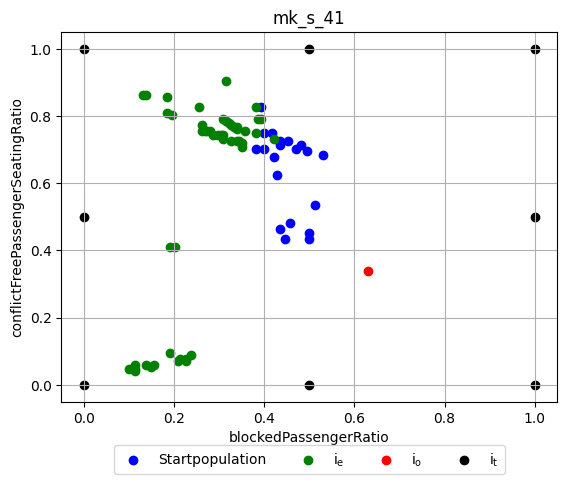

In [36]:
with open('mk_s_41.json', 'r') as f:
    problem_instance = json.load(f)
f.close

conflict_coordinates = [{"blockedPassengerRatio": 0.0, "conflictFreePassengerSeatingRatio": 1.0}, 
            {"blockedPassengerRatio": 0.5, "conflictFreePassengerSeatingRatio": 1.0}, 
            {"blockedPassengerRatio": 1.0, "conflictFreePassengerSeatingRatio": 1.0}, 
            {"blockedPassengerRatio": 1.0, "conflictFreePassengerSeatingRatio": 0.5}, 
            {"blockedPassengerRatio": 1.0, "conflictFreePassengerSeatingRatio": 0.0}, 
            {"blockedPassengerRatio": 0.5, "conflictFreePassengerSeatingRatio": 0.0}, 
            {"blockedPassengerRatio": 0.0, "conflictFreePassengerSeatingRatio": 0.0}, 
            {"blockedPassengerRatio": 0.0, "conflictFreePassengerSeatingRatio": 0.5}] 

evo_data_experiment_id = "ev-mks41_3"

#conflict_evolution_data.delete_many({"experimentId" : evo_data_experiment_id})

post_conflict_evolution(evo_data_experiment_id, problem_instance, "MoveOptimalRailCarriageMutation", conflict_coordinates)

conflict_evolution = list(conflict_evolution_data.find({"experimentId" : evo_data_experiment_id}))

for ce in conflict_evolution:
    plt = plot_conflict_evolution(ce)
    xs = list(map(lambda x: x["blockedPassengerRatio"], conflict_coordinates))
    ys = list(map(lambda x: x["conflictFreePassengerSeatingRatio"], conflict_coordinates))
    plt.scatter(xs, ys, color='black',label = "$\mathregular{i_t}$")


    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.10),ncol=4)
    
    plt.show()